In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as tfmetrics
import tensorflow.contrib.rnn as tfrnn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


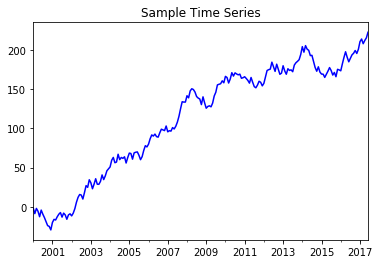

In [2]:
random.seed(101)
rng = pd.date_range(start='2000', periods=210, freq='M')
ts = pd.Series(np.random.uniform(-8, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Sample Time Series')
plt.show()

In [3]:
tsa = np.array(ts)
num_periods = 20
f_horizon = 1
x_data = tsa[:(len(tsa)-(len(tsa) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)
y_data = tsa[1:(len(tsa) - (len(tsa) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
def split_data(series, forecast, num_periods):
    test_x_setup = tsa[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = tsa[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY
X_test, Y_test = split_data(tsa, f_horizon, num_periods)

In [5]:
tf.reset_default_graph()
inputs = 1
hidden = 200
output = 1
learning_rate = 0.001
x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden, activation = tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])
loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [6]:
epochs = 2000
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {x : x_batches, y : y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict = {x : x_batches, y : y_batches})
            print(ep, "\tMSE: ", mse)
    y_pred = sess.run(outputs, feed_dict = {x : X_test})
    outputs = tf.reshape(stacked_outputs, [-1, num_periods, output], name="output")
    constant_graph = \
       tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["output"])
    with tf.gfile.FastGFile('./rnn_ts_model.pb', 'wb') as f:
        f.write(constant_graph.SerializeToString())

0 	MSE:  3303719.2
100 	MSE:  53425.71
200 	MSE:  9468.973
300 	MSE:  2987.074
400 	MSE:  2145.6633
500 	MSE:  1774.2594
600 	MSE:  1563.2361
700 	MSE:  1432.9978
800 	MSE:  1210.2698
900 	MSE:  1099.3605
1000 	MSE:  920.8389
1100 	MSE:  837.6603
1200 	MSE:  806.1492
1300 	MSE:  917.6068
1400 	MSE:  671.60706
1500 	MSE:  633.1609
1600 	MSE:  602.0137
1700 	MSE:  578.821
1800 	MSE:  1228.4619
1900 	MSE:  589.76733
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.


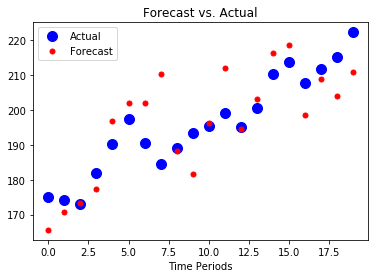

In [7]:
plt.title("Forecast vs. Actual", fontsize=12)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label = "Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label = "Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()